In [1]:
CONSTRAINT_TOOLS = '/scratch/ucgd/lustre-work/quinlan/u6018199/constraint-tools'
CONSTRAINT_TOOLS_DATA = '/scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools'

import sys
sys.path.append(f'{CONSTRAINT_TOOLS}/utilities')

## Assign scores to Chen windows 

In [2]:
import pandas as pd
import numpy as np

from shell import shell 
from colorize import print_string_as_info
from aggregate import aggregate

def get_header(filename):
  with open(filename) as fh: 
    header = fh.readline().strip().split('\t')
  return header

def intersect(a_filename, b_filename, intersect_filename): 
  cmd = (
    f'bedtools intersect'
    f" -a <(tail -n +2 {a_filename})" # contains header
    f" -b <(cat {b_filename})"        # does not contain header
    f' -wao -f 0.5'
    f' > {intersect_filename}'
  )
  shell(cmd)
  print_string_as_info(f'Wrote {intersect_filename}')

  a_file_header = get_header(a_filename)               # contains header
  b_file_header = ['B_chrom', 'B_start', 'B_end', 'B'] # does not contain header

  return a_file_header, b_file_header

def set_column_dtypes(df, column_dtypes, log=False): 
  for col, dtype in column_dtypes.items(): 
    df[col] = df[col].astype(dtype)

  if log: print(dict(df.dtypes))
  return df 

def make_scores_numeric(df): 
  # we don't want to include enhancers that don't overlap any windows with B-values
  df = df[df['B_chrom'] != '.'] 

  # having removed records where 'B_chrom' is '.', we can now convert the column to a float
  df = set_column_dtypes(
    df,   
    column_dtypes = {
      'B': float,
    }
  )

  return df 
  
def assign_scores_to_chen_windows():
  df_gnocchi = pd.read_csv(
    f'{CONSTRAINT_TOOLS_DATA}/chen-et-al-2023-published-version/41586_2023_6045_MOESM4_ESM/Supplementary_Data_2-gnocchi.bed',
    sep='\t',
    names=['chrom', 'start', 'end', 'gnocchi']
  )
  df_N_expected = pd.read_csv(
    f'{CONSTRAINT_TOOLS_DATA}/chen-et-al-2023-published-version/41586_2023_6045_MOESM4_ESM/Supplementary_Data_2-N_expected_gnocchi.bed',
    sep='\t',
    names=['chrom', 'start', 'end', 'N_expected']
  )
  df_N_observed = pd.read_csv(
    f'{CONSTRAINT_TOOLS_DATA}/chen-et-al-2023-published-version/41586_2023_6045_MOESM4_ESM/Supplementary_Data_2-N_observed.bed',
    sep='\t',
    names=['chrom', 'start', 'end', 'N_observed']
  )

  df = pd.merge(
    df_gnocchi, 
    df_N_expected, 
    on=['chrom', 'start', 'end'],
    how='inner'
  )
  df = pd.merge(
    df, 
    df_N_observed, 
    on=['chrom', 'start', 'end'],
    how='inner'
  )

  # Chen et al windows: 
  a_filename = f'{CONSTRAINT_TOOLS_DATA}/chen-et-al-2023-published-version/41586_2023_6045_MOESM4_ESM/Supplementary_Data_2.gnocchi.N_expected.N_observed.bed' 
  df.to_csv(
    a_filename,
    sep='\t',
    index=False,
  )

  # assign B-values to Chen et al. windows 
  b_filename = f'{CONSTRAINT_TOOLS_DATA}/background-selection/CADD-B-map/bmap.hg38.bed' 
  intersect_filename = f'{CONSTRAINT_TOOLS_DATA}/chen-et-al-2023-published-version/41586_2023_6045_MOESM4_ESM/Supplementary_Data_2.gnocchi.N_expected.N_observed.intersect.bmap.bed'

  a_file_header, b_file_header = intersect(a_filename, b_filename, intersect_filename)

  df = pd.read_csv(
    intersect_filename, 
    sep='\t',
    names=a_file_header + b_file_header + ['chenWindow_BWindow_overlap'],
  )

  df = make_scores_numeric(df)

  # though unlikely, some Chen-windows may intersect multiple B-windows, 
  # so let's group by Chen-window, and aggregare scores over all B-windows in the group
  df = aggregate(
    df, 
    group_columns = a_file_header,
    aggregation_functions = {
      'B': [np.max],
    }
  )

  df = df.rename(columns={'max B': 'B'})

  return df

pd.set_option('display.max_columns', 100)

WINDOWS = assign_scores_to_chen_windows()
WINDOWS

Wrote /scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools/chen-et-al-2023-published-version/41586_2023_6045_MOESM4_ESM/Supplementary_Data_2.gnocchi.N_expected.N_observed.intersect.bmap.bed
<ipython-input-2-668d11f86fdf>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(dtype)


,chrom,start,end,gnocchi,N_expected,N_observed,B
0,chr1,1432000,1433000,4.299894,338.059552,259,0.653
1,chr1,1435000,1436000,3.331645,333.876799,273,0.652
2,chr1,1449000,1450000,1.817267,253.960193,225,0.652
3,chr1,1450000,1451000,1.365863,337.076763,312,0.652
4,chr1,1451000,1452000,0.666316,302.590657,291,0.652
...,...,...,...,...,...,...,...
1605781,chr9,137269000,137270000,5.276351,300.458958,209,0.536
1605782,chr9,137275000,137276000,2.687348,339.517045,290,0.536
1605783,chr9,137282000,137283000,-0.090791,208.688422,210,0.536
1605784,chr9,137290000,137291000,2.162811,257.721105,223,0.536


## For those Chen windows subject to strong BGS, the model overestimates the observed SNV count more often than it underestimates it

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
# from sklearn.linear_model import LinearRegression

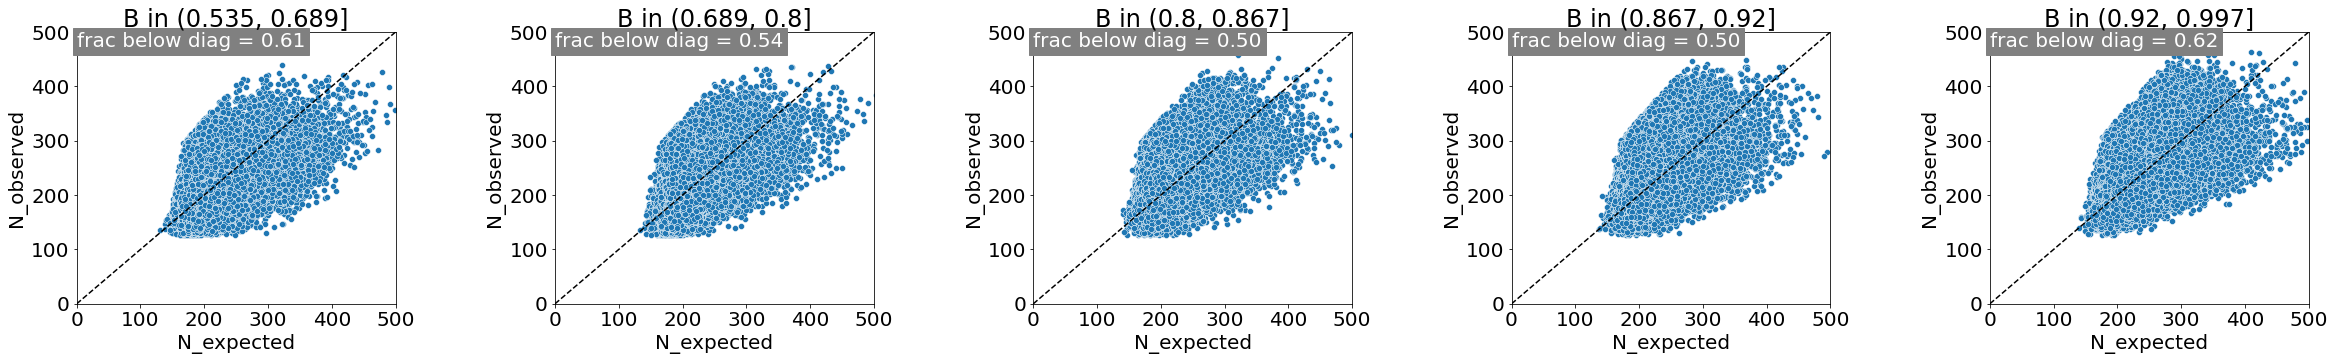

In [4]:
plt.rcParams.update({
  'font.size': 20,
})

def correlate_observed_counts_with_expected_counts(df, number_b_quantiles=5): 
  df = df.copy() 
  
  df['B_range'] = pd.qcut(df['B'], q=number_b_quantiles, labels=None, retbins=False)

  fig, axs = plt.subplots(1, number_b_quantiles, figsize=(40, 5))
  plt.subplots_adjust(wspace=0.5)
  for i, b_quantile in enumerate(sorted(df['B_range'].unique())): 
    df_b_range = df[df['B_range'] == b_quantile]
    sns.scatterplot(
      data=df_b_range, 
      x='N_expected', 
      y='N_observed', 
      ax=axs[i],
    )
    axs[i].plot([0, 500], [0, 500], color='black', linestyle='--')
    axs[i].set_title(f'B in {b_quantile}')

    # r = df_b_range['N_expected'].corr(df_b_range['N_observed'])
    # axs[i].text(50, 500, f'r = {r:.2f}', ha='left', va='top', backgroundcolor='grey', color='white')

    fraction_below_diagonal = (df_b_range['N_observed'] < df_b_range['N_expected']).sum() / len(df_b_range)
    axs[i].text(0, 500, f'frac below diag = {fraction_below_diagonal:.2f}', ha='left', va='top', backgroundcolor='grey', color='white')

    # gnocchi_threshold = 3
    # fraction_gnocchi = (df_b_range['gnocchi'] > gnocchi_threshold).sum() / len(df_b_range)
    # axs[i].text(0, 450, f'frac gnocchi > {gnocchi_threshold} = {fraction_gnocchi:.3f}', ha='left', va='top', backgroundcolor='grey', color='white')
  
    # x = df_b_range['N_expected']
    # y = df_b_range['N_observed']
    # model = LinearRegression()
    # model.fit(x.values.reshape(-1, 1), y)
    # slope = model.coef_[0]
    # intercept = model.intercept_
    # axs[i].text(50, 400, f'slope = {slope:.2f}', ha='left', va='top', backgroundcolor='grey', color='white')
    # xs = np.array([0, 500])
    # ys = slope * xs + intercept
    # axs[i].plot(xs, ys, color='red', linestyle='--')

    axs[i].set_xlim(0, 500)
    axs[i].set_ylim(0, 500)

correlate_observed_counts_with_expected_counts(WINDOWS)

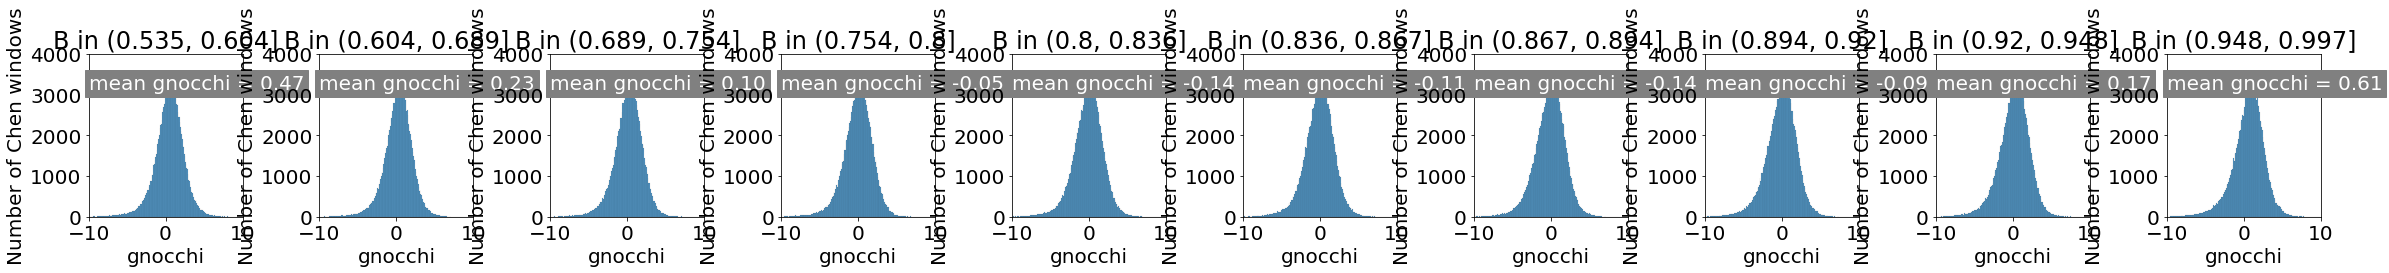

In [5]:
def plot_gnocchi_distribution(df, number_of_b_quantiles=10): 
  df = df.copy() 
  
  df['B_range'] = pd.qcut(df['B'], q=number_of_b_quantiles, labels=None, retbins=False)

  fig, axs = plt.subplots(1, number_of_b_quantiles, figsize=(40, 3))
  plt.subplots_adjust(wspace=0.5)
  for i, b_quantile in enumerate(sorted(df['B_range'].unique())): 
    df_b_range = df[df['B_range'] == b_quantile]
    sns.histplot(
      data=df_b_range, 
      x='gnocchi', 
      ax=axs[i],
    )
    axs[i].set_title(f'B in {b_quantile}')
    axs[i].set_xlim(-10, 10)
    axs[i].set_ylim(0, 4000)
    axs[i].set_ylabel('Number of Chen windows')
    mean_gnocchi = df_b_range['gnocchi'].mean()
    axs[i].text(-10, 3500, f'mean gnocchi = {mean_gnocchi:.2f}', ha='left', va='top', backgroundcolor='grey', color='white')

plot_gnocchi_distribution(WINDOWS)

## Compute and save naive BGS-corrected Gnocchi 

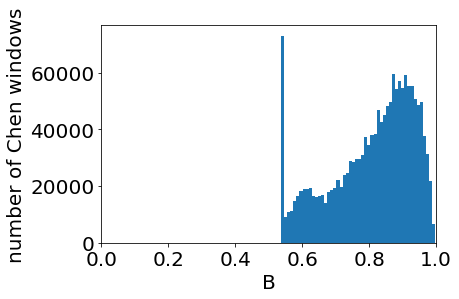

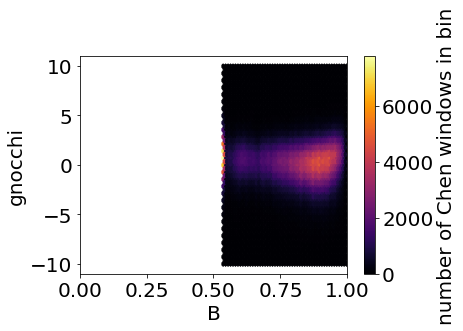

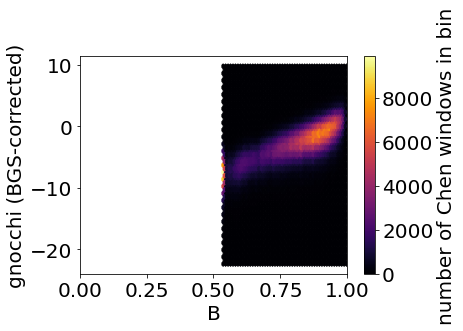

Wrote /scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools/chen-et-al-2023-published-version/41586_2023_6045_MOESM4_ESM/Supplementary_Data_2.gnocchi.bmap.gnocchi_BGS_corrected_naive.bed


In [6]:
def compute_BGS_corrected_gnocchi(df): 
  df = df.copy() 
  
  plt.hist(df['B'], bins=50)
  plt.xlabel('B')
  plt.ylabel('number of Chen windows')
  plt.xlim(0, 1)
  plt.show()

  plt.hexbin(df['B'], df['gnocchi'], gridsize=50, cmap='inferno')
  plt.colorbar(label='number of Chen windows in bin')
  plt.xlabel('B')
  plt.ylabel('gnocchi')
  plt.xlim(0, 1)
  plt.show() 

  df['N_expected_BGS_corrected'] = df['N_expected'] * df['B']
  df['gnocchi_BGS_corrected'] = (df['N_expected_BGS_corrected'] - df['N_observed']) / np.sqrt(df['N_expected_BGS_corrected'])

  plt.hexbin(df['B'], df['gnocchi_BGS_corrected'], gridsize=50, cmap='inferno')
  plt.colorbar(label='number of Chen windows in bin')
  plt.xlabel('B')
  plt.ylabel('gnocchi (BGS-corrected)')
  plt.xlim(0, 1)
  plt.show() 
  
  filename = f'{CONSTRAINT_TOOLS_DATA}/chen-et-al-2023-published-version/41586_2023_6045_MOESM4_ESM/Supplementary_Data_2.gnocchi.bmap.gnocchi_BGS_corrected_naive.bed'
  df.to_csv(
    filename,
    sep='\t',
    index=False,
  )
  print(f'Wrote {filename}')

compute_BGS_corrected_gnocchi(WINDOWS)

## For each B-stratum, correct Gnocchi by shifting N_expected so that it is lower than N_observed just as often as it is higher

In [10]:
def find_shift_value(pairs):
  n = len(pairs)
  left, right = 0, 100
  while right - left > 1:  
    mid = (left + right) / 2
    count_below_diag = sum(x - mid > y for x, y in pairs)
    if count_below_diag >= n / 2:
      left = mid
    else:
      right = mid
  return (left + right) / 2  

def correct_gnocchi(df): 
  pairs = [(x, y) for x, y in zip(df['N_expected'], df['N_observed'])]
  shift_value = find_shift_value(pairs)
  df['N_expected_BGS_corrected'] = df['N_expected'] - shift_value
  df['gnocchi_BGS_corrected'] = (df['N_expected_BGS_corrected'] - df['N_observed']) / np.sqrt(df['N_expected_BGS_corrected'])
  return df

def correct_gnocchi_by_bin(df, number_B_bins): 
  df = df.copy() 
  df['B_bin'] = pd.cut(df['B'], bins=number_B_bins)
  dfs = [correct_gnocchi(group) for _, group in df.groupby('B_bin')]
  return pd.concat(dfs)

correct_gnocchi_by_bin(WINDOWS, 10)

,chrom,start,end,gnocchi,N_expected,N_observed,B,B_bin,N_expected_BGS_corrected,gnocchi_BGS_corrected
13306,chr1,26665000,26666000,0.738653,208.670152,198,0.582,"(0.536, 0.582]",199.685777,0.119296
13307,chr1,26668000,26669000,0.986173,186.466461,173,0.579,"(0.536, 0.582]",177.482086,0.336436
13308,chr1,26670000,26671000,2.610602,199.911299,163,0.576,"(0.536, 0.582]",190.926924,2.021108
13309,chr1,26672000,26673000,1.992740,218.453009,189,0.574,"(0.536, 0.582]",209.468634,1.414260
13310,chr1,26674000,26675000,2.080116,209.077458,179,0.572,"(0.536, 0.582]",200.093083,1.491159
...,...,...,...,...,...,...,...,...,...,...
1605481,chr9,136055000,136056000,4.940620,329.711581,240,0.953,"(0.951, 0.997]",318.383456,4.392878
1605482,chr9,136061000,136062000,3.950215,316.248127,246,0.960,"(0.951, 0.997]",304.920002,3.374192
1605483,chr9,136062000,136063000,2.456219,254.157846,215,0.960,"(0.951, 0.997]",242.829721,1.785903
1605484,chr9,136063000,136064000,1.805618,262.239857,233,0.960,"(0.951, 0.997]",250.911732,1.130777


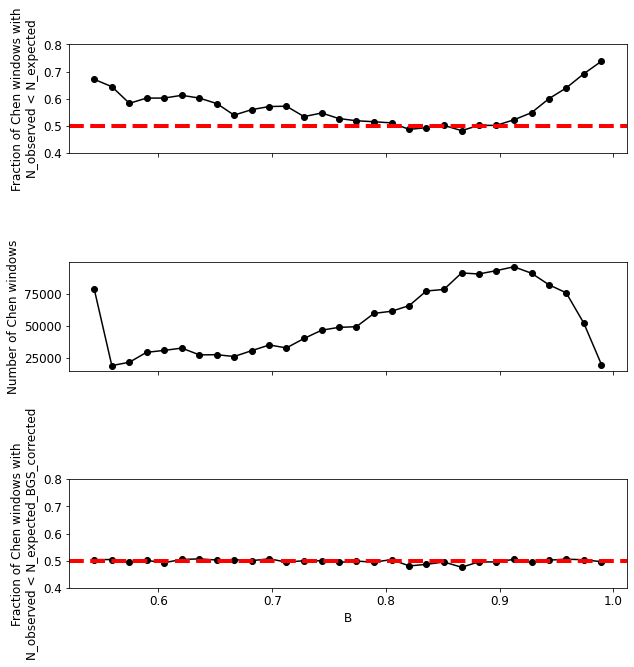

In [11]:
plt.rcParams.update({
  'font.size': 12,
})

def plot_fraction_below_diag(df, number_B_bins=30):  
  df = correct_gnocchi_by_bin(WINDOWS, number_B_bins)
  
  # Compute midpoint of each 'B_bin'
  df['B_bin_mid'] = df['B_bin'].apply(lambda x: x.mid).astype(float)

  df['below_diag'] = df['N_observed'] < df['N_expected']
  df['below_diag_corrected'] = df['N_observed'] < df['N_expected_BGS_corrected']

  df = aggregate(
    df, 
    group_columns = ['B_bin_mid'],
    aggregation_functions = {
      'below_diag': [np.mean],
      'below_diag_corrected': [np.mean],
      'B': ['count']
    }
  )
  df = df.rename(columns={
    'mean below_diag': 'fraction_below_diag',
    'mean below_diag_corrected': 'fraction_below_diag_corrected',
  })
  
  fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
  fig.subplots_adjust(hspace=1)

  axs[0].plot(df['B_bin_mid'], df['fraction_below_diag'], 'o-', color='black')
  axs[0].axhline(y=0.5, color='red', linestyle='--', linewidth=4)
  axs[0].set_ylabel('Fraction of Chen windows with\nN_observed < N_expected')
  axs[0].set_ylim(0.4, 0.8)

  axs[1].plot(df['B_bin_mid'], df['count B'], 'o-', color='black')
  axs[1].set_ylabel('Number of Chen windows')

  axs[2].plot(df['B_bin_mid'], df['fraction_below_diag_corrected'], 'o-', color='black')
  axs[2].axhline(y=0.5, color='red', linestyle='--', linewidth=4)
  axs[2].set_ylabel('Fraction of Chen windows with\nN_observed < N_expected_BGS_corrected')
  axs[2].set_ylim(0.4, 0.8)
  axs[2].set_xlabel('B')

plot_fraction_below_diag(WINDOWS)  
